# Мультикласова класифікація

Будемо працювати з наступним набором даних:
https://archive.ics.uci.edu/ml/datasets/car+evaluation

Ми передбачимо клас автомобілів відповідно до його характеристик. Клас може бути unacceptable, acceptable, good, very good.


In [118]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score,
                             confusion_matrix, 
                             classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, ElasticNet

In [115]:
!pip install graphviz
!pip install pydotplus

1.1. Завантажимо набір даних у змінну df за допомогою Pandas. Виведемо перші 5 записів та форму набору даних.

In [82]:
df = pd.read_csv(r"C:\Data\hw_5_data.csv")
print(df)

      vhigh vhigh.1      2   2.1  small   low  unacc
0     vhigh   vhigh      2     2  small   med  unacc
1     vhigh   vhigh      2     2  small  high  unacc
2     vhigh   vhigh      2     2    med   low  unacc
3     vhigh   vhigh      2     2    med   med  unacc
4     vhigh   vhigh      2     2    med  high  unacc
...     ...     ...    ...   ...    ...   ...    ...
1722    low     low  5more  more    med   med   good
1723    low     low  5more  more    med  high  vgood
1724    low     low  5more  more    big   low  unacc
1725    low     low  5more  more    big   med   good
1726    low     low  5more  more    big  high  vgood

[1727 rows x 7 columns]


In [83]:
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [84]:
df.shape

(1727, 7)

1.2. Набір даних не має імен стовпців. Даємо наступні імена стовпцям:
`['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']`

In [85]:
df.columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [86]:
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


2. Виведемо кількість зустрічей кожної з незалежних змінних програмно.

In [87]:
df['buying'].value_counts()

high     432
med      432
low      432
vhigh    431
Name: buying, dtype: int64

In [88]:
df['maint'].value_counts()

high     432
med      432
low      432
vhigh    431
Name: maint, dtype: int64

In [89]:
df['doors'].value_counts()

3        432
4        432
5more    432
2        431
Name: doors, dtype: int64

In [90]:
df['persons'].value_counts()

4       576
more    576
2       575
Name: persons, dtype: int64

In [91]:
df['lug_boot'].value_counts()

med      576
big      576
small    575
Name: lug_boot, dtype: int64

In [92]:
df['safety'].value_counts()

med     576
high    576
low     575
Name: safety, dtype: int64

3. Виведемо скільки рядків відповідають кожному із значень цільової змінної. 

In [93]:
df['class'].value_counts()

unacc    1209
acc       384
good       69
vgood      65
Name: class, dtype: int64

Це порядкова змінна, так як присутній відповідний порядок (unacc,acc,good,vgood), на відміну від номінальної змінної, у якої відсутній такий порядок (наприклад, є лише два варіанти "так" або "ні").
Класифікація незбалансована, оскільки кількість спостережень не однакова для всіх класів у наборі класифікаційних даних (кількість спостережень класу unacc на багато більша, ніж класів good та vgood).

4. Перевіримо, чи є відсутні значення.

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1727 non-null   object
 1   maint     1727 non-null   object
 2   doors     1727 non-null   object
 3   persons   1727 non-null   object
 4   lug_boot  1727 non-null   object
 5   safety    1727 non-null   object
 6   class     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [95]:
df[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']].isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

5.1. Запишемо у змінну `X` всі незалежні змінні, у змінну `y` - цільову.


In [96]:
X = df.drop(["class"],axis=1)
y = df["class"]

5.2. Розіб'ємо дані на тренувальний та тестовий набори. Визначаємо random_state рівним 42 та test_size рівним 0.33.

In [97]:
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42, stratify=y)

5.3. Виведемо форму та перші 5 записів отриманих X_train_df, X_test_df.

In [98]:
X_train_df.shape

(1157, 6)

In [99]:
X_train_df.head()

,buying,maint,doors,persons,lug_boot,safety
1329,low,vhigh,3,2,big,med
1593,low,med,5more,2,small,med
949,med,vhigh,5more,2,med,high
1609,low,med,5more,4,big,high
1096,med,med,2,4,big,high


In [100]:
X_test_df.shape

(570, 6)

In [101]:
X_test_df.head()

,buying,maint,doors,persons,lug_boot,safety
1199,med,low,2,4,med,low
853,high,low,5more,4,big,high
1294,med,low,5more,more,big,high
1589,low,med,4,more,big,low
857,high,low,5more,more,med,low


6.1. Виведимо типи даних усіх змінних у X_train.

In [102]:
X_train_df.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

6.2. Усі незалежні змінні у нас ординальні. Закодуємо всі незалежні змінні за допомогою відповідного методу з sklearn.preprocessing.  
Необхідно встановити правильний порядок значень для кожної змінної при кодуванні так, щоб значення після кодування були впорядковані в порядку зростання.
Результат кодування X_train_df та X_test_df запишемо відповідно у X_train, X_test.

In [104]:
encoder = OrdinalEncoder(categories=[
    ['low', 'med', 'high', 'vhigh'], # buying
    ['low', 'med', 'high', 'vhigh'], # maint
    ['2', '3', '4', '5more'], # doors
    ['2', '4', 'more'], # persons
    ['small', 'med', 'big'], # lug_boot
    ['low', 'med', 'high'] #safety
])
encoder.fit(X)

X_train = encoder.transform(X_train_df)
X_test = encoder.transform(X_test_df)

X_train = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test = pd.DataFrame(X_test, columns=X_test_df.columns)

6.3. Виведемо перші 5 записів X_train, X_test.

In [105]:
X_train.head(5), X_test.head(5)

(   buying  maint  doors  persons  lug_boot  safety
 0     0.0    3.0    1.0      0.0       2.0     1.0
 1     0.0    1.0    3.0      0.0       0.0     1.0
 2     1.0    3.0    3.0      0.0       1.0     2.0
 3     0.0    1.0    3.0      1.0       2.0     2.0
 4     1.0    1.0    0.0      1.0       2.0     2.0,
    buying  maint  doors  persons  lug_boot  safety
 0     1.0    0.0    0.0      1.0       1.0     0.0
 1     2.0    0.0    3.0      1.0       2.0     2.0
 2     1.0    0.0    3.0      2.0       2.0     2.0
 3     0.0    1.0    2.0      2.0       2.0     0.0
 4     2.0    0.0    3.0      2.0       1.0     0.0)

6.4. Виведемо отримані категорії енкодера.

In [106]:
ordinal_encoder.categories_

[array(['high', 'low', 'med', 'vhigh'], dtype=object),
 array(['high', 'low', 'med', 'vhigh'], dtype=object),
 array(['2', '3', '4', '5more'], dtype=object),
 array(['2', '4', 'more'], dtype=object),
 array(['big', 'med', 'small'], dtype=object),
 array(['high', 'low', 'med'], dtype=object)]

7.1. Навчимо на отриманих даних логістичну регресію c random_state=42 та іншими параметрами за промовчуванням.

In [107]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

7.2. Зробимо прогнози за допомогою отриманої моделі та методу predict. 

In [108]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

7.3. Виведемо метрики якості за допомогою classification_report.

In [109]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         acc       0.67      0.54      0.60       127
        good       0.65      0.48      0.55        23
       unacc       0.87      0.94      0.90       399
       vgood       0.75      0.71      0.73        21

    accuracy                           0.82       570
   macro avg       0.74      0.67      0.70       570
weighted avg       0.81      0.82      0.82       570



In [110]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         acc       0.68      0.61      0.65       257
        good       0.53      0.35      0.42        46
       unacc       0.88      0.93      0.91       810
       vgood       0.80      0.75      0.78        44

    accuracy                           0.83      1157
   macro avg       0.73      0.66      0.69      1157
weighted avg       0.82      0.83      0.82      1157



Для порівння різних моделей та вибору найкращої доцільніше використовувати таку метрику (одне число, що характеризує якість передбачень моделі) як F1 score, оскільки вона дає уявлення про середню якість моделі. А взагалі потрібно вибирати в залежності від поставленої задачі. 

8.1. Навчимо Decision Tree з sklearn з глибиною 4 за тими ж даними. Обчислимо прогнози, знайдемо метрику якості на test даних. Порівняємо з регресією логістики.

In [112]:
clf_tree = tree.DecisionTreeClassifier(max_depth=4)
clf_tree.fit(X_train, y_train)

y_pred_train = clf_tree.predict(X_train)
y_pred_test = clf_tree.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         acc       0.75      0.75      0.75       257
        good       0.36      1.00      0.53        46
       unacc       0.97      0.92      0.94       810
       vgood       0.00      0.00      0.00        44

    accuracy                           0.85      1157
   macro avg       0.52      0.67      0.55      1157
weighted avg       0.86      0.85      0.85      1157

              precision    recall  f1-score   support

         acc       0.74      0.72      0.73       127
        good       0.36      1.00      0.53        23
       unacc       0.97      0.93      0.95       399
       vgood       0.00      0.00      0.00        21

    accuracy                           0.85       570
   macro avg       0.52      0.66      0.55       570
weighted avg       0.86      0.85      0.85       570



f1-score стала гіршою. Також можна помітити, що точність покращилась. Цей приклад гарно візуалізує, що точність тут працює не дуже добре. Модель не змогла передбачити жодного very good автомобіля

8.2. Виведемо параметри моделі Decision Tree.

In [113]:
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

8.3. Візуалізуємо отримане дерево. Зображення буде мати графік з критеріями у вузлах, класах та кількості елементів у кожному аркуші.

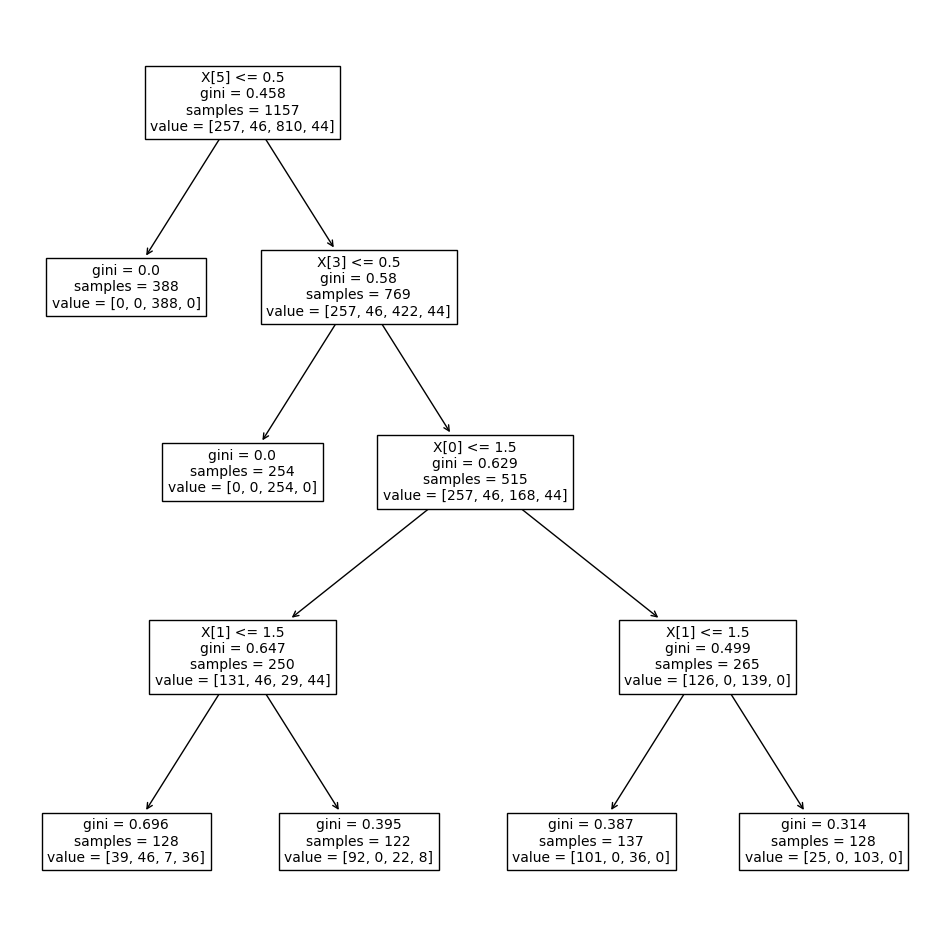

In [124]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf_tree, fontsize=10)
plt.show()

9.1. Виконаємо пошук гіперпараметрів для DecisionTree за сіткою за допомогою sklearn. Встановимо сітку з параметрів самостійно на основі припущень, що може покращити роботу дерева.

In [128]:
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': range(2, 30)
}

clf = tree.DecisionTreeClassifier()
    
grid_searcher = GridSearchCV(
    clf,
    param_grid,
    cv = 5
    )
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_split': range(2, 30)})

9.2. Виведемо claasification report фінальної моделі пошуку гіперпараметрів.

In [129]:
best_tree = grid_searcher.best_estimator_
y_pred_train = best_tree.predict(X_train)
y_pred_test = best_tree.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         acc       0.98      1.00      0.99       257
        good       0.98      1.00      0.99        46
       unacc       1.00      0.99      1.00       810
       vgood       1.00      0.98      0.99        44

    accuracy                           0.99      1157
   macro avg       0.99      0.99      0.99      1157
weighted avg       0.99      0.99      0.99      1157

              precision    recall  f1-score   support

         acc       0.95      0.99      0.97       127
        good       0.96      0.96      0.96        23
       unacc       1.00      0.99      0.99       399
       vgood       1.00      0.95      0.98        21

    accuracy                           0.99       570
   macro avg       0.98      0.97      0.97       570
weighted avg       0.99      0.99      0.99       570



9.3. Виводимо матрицю помилок для кращої моделі у пошуку гіперпараметрів. Відображаємо матрицю візуально.

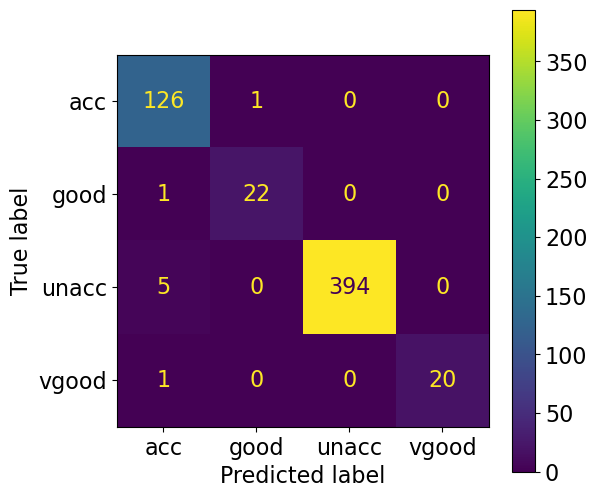

In [131]:
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_tree.classes_)

disp.plot(ax=ax)
plt.rcParams.update({'font.size': 16})
plt.show()

В цілому вдалося побудувати досить якісну модель. Єдине, іноді модель перебачає accurate class для екземплярів інших класів.